In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
upsample = nn.Upsample(size=(2200, 1700), mode='nearest')

In [3]:
Image_Folder = 'Images'
Model_Folder = 'models'
Result_Folder = 'Results'
SubFolder = 'VDSR'
Data_Folder = 'data'
High_Res_Folder = 'Actual_Images\\High_Res'
Low_Res_Folder = 'Actual_Images\\Low_Res_Watermark_Removed'
High_Res_Online_Folder = 'Actual_Images\\High_Res_Online'
Low_Res_Online_Folder = 'Actual_Images\\Low_Res_Online_Watermark_Removed'
High_Res_Other_Folder = 'Church_Music_Extracted\\High_Res'
Low_Res_Other_Folder = 'Church_Music_Extracted\\Low_Res_Watermark_Removed'

image_dir_path = os.path.join(Image_Folder, SubFolder)
os.makedirs(image_dir_path, exist_ok=True)

model_dir_path = os.path.join(Model_Folder, SubFolder)
os.makedirs(model_dir_path, exist_ok=True)

result_dir_path = os.path.join(Result_Folder, SubFolder)
os.makedirs(result_dir_path, exist_ok=True)

In [4]:
def plot_images(X_upscaled, X_pred, y, kind):
    plt.figure(figsize=(70,70))
    plt.subplot(1, 3, 1)
    plt.imshow(X_upscaled[0].cpu().detach().squeeze(), cmap='gray')
    plt.title(f"{kind} Original")
    plt.subplot(1, 3, 2)
    plt.imshow(X_pred[0].cpu().detach().squeeze(), cmap='gray')
    plt.title(f"{kind} Predicted")
    plt.subplot(1, 3, 3)
    plt.imshow(y[0].cpu().detach().squeeze(), cmap='gray')
    plt.title(f"{kind} Actual")
    plt.show()

In [5]:
def save_plot(file_name, dir_path, plt): 
    # Construct the full path for the image
    full_path = os.path.join(dir_path, file_name)
    
    # Save the plot
    plt.savefig(full_path)
    
    # Print a message indicating the image has been saved
    print(f"Image has been saved at {full_path}")

# Train Functions

In [6]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [7]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               patch_height: int, 
               patch_width: int,
               device=device,
               print_images=0):

    if 2200 % patch_height != 0 or 1700 % patch_width != 0:
        raise ValueError("Image dimensions must be evenly divisible by patch dimensions.")

    model.train()

    train_loss = 0

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X, y = X.to(device), y.to(device)

        # Upscale the image to 1700x2200
        X_upscaled = upsample(X)

        num_segments = (X_upscaled.shape[-2] // patch_height) * (X_upscaled.shape[-1] // patch_width)

        batch_loss = 0

        # Create empty tensors to store the predicted images
        X_pred = torch.zeros_like(X_upscaled)

        # Iterate over patches
        optimizer.zero_grad()
        for i in range(0, X_upscaled.shape[-2], patch_height):
            for j in range(0, X_upscaled.shape[-1], patch_width):
                X_patch = X_upscaled[:, :, i:i+patch_height, j:j+patch_width]
                y_patch = y[:, :, i:i+patch_height, j:j+patch_width]

                # Pass through the model
                X_pred_patch = model(X_patch)

                # Place the predicted patch into the correct location
                X_pred[:, :, i:i+patch_height, j:j+patch_width] = X_pred_patch
                
                # Check if the image has only one channel and convert to 3-channel
                if X_pred_patch.shape[1] == 1:
                    X_pred_patch = X_pred_patch.repeat(1, 3, 1, 1)
                if y_patch.shape[1] == 1:
                    y_patch = y_patch.repeat(1, 3, 1, 1)

                # Calculate the loss
                loss = loss_fn(X_pred_patch, y_patch)
                batch_loss += loss.item()

                # Backward only, not optimization
                loss.backward()

        # Move optimization step here, outside of the nested loop
        optimizer.step()

        batch_loss /= num_segments

        # Accumulate the batch loss
        train_loss += batch_loss

        if print_images > 0:
            if batch % print_images == 0:
                plot_images(X_upscaled, X_pred, y, "Train")
                
        # Print the training loss
        print(f"\rBatch {batch + 1}: Training Loss: {batch_loss:6f}", end="")

    # Divide the accumulated loss by the total number of batches
    train_loss = train_loss / len(dataloader)

    return train_loss

In [8]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             patch_height: int, 
             patch_width: int,
             device=device,
             print_images=0):
    
    if 2200 % patch_height != 0 or 1700 % patch_width != 0:
        raise ValueError("Image dimensions must be evenly divisible by patch dimensions.")

    # Switches the model to evaluation mode
    model.eval()

    # Initialize variable to store total validation loss
    val_loss = 0

    # Disable calculation of gradients for performance boost during inference
    with torch.inference_mode():
        
        for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
            X, y = X.to(device), y.to(device)

            # Upscale the image to 1700x2200
            X_upscaled = upsample(X)
            
            num_segments = (X_upscaled.shape[-2] // patch_height) * (X_upscaled.shape[-1] // patch_width)
            
            batch_loss = 0

            # Create empty tensors to store the predicted images
            X_pred = torch.zeros_like(X_upscaled)

            # Iterate over the specified pixel patches
            for i in range(0, X_upscaled.shape[-2], patch_height):
                for j in range(0, X_upscaled.shape[-1], patch_width):
                    X_patch = X_upscaled[:, :, i:i+patch_height, j:j+patch_width]
                    y_patch = y[:, :, i:i+patch_height, j:j+patch_width]

                    # Pass through the model
                    X_pred_patch = model(X_patch)

                    # Place the predicted patch into the correct location
                    X_pred[:, :, i:i+patch_height, j:j+patch_width] = X_pred_patch
                               
                    # Check if the image has only one channel and convert to 3-channel
                    if X_pred_patch.shape[1] == 1:
                        X_pred_patch = X_pred_patch.repeat(1, 3, 1, 1)
                    if y_patch.shape[1] == 1:
                        y_patch = y_patch.repeat(1, 3, 1, 1)
                            
                    # Calculate the loss
                    loss = loss_fn(X_pred_patch, y_patch)
                    batch_loss += loss.item()

            # Add up the loss values and normalize by the number of segments
            batch_loss /= num_segments

            # Accumulate the validation loss
            val_loss += batch_loss
            
            if print_images > 0:
                if batch % print_images == 0:
                    plot_images(X_upscaled, X_pred, y, "Test")

            # Print the validation loss
            print(f"\rBatch {batch + 1}: Validation Loss: {batch_loss:6f}", end="")
            
    # Calculate average validation loss by dividing by the total number of batches
    val_loss = val_loss / len(dataloader)
    return val_loss # Return average validation loss

In [9]:
def train(model_name: str,
          model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          patch_height: int = 100, 
          patch_width: int = 100,
          max_epochs: int = 3,
          save_epochs: int = 1,
          device=device,
          load_model: bool = True,
          save_model: bool = True,
          continue_training: bool = False,
          print_images: int = 0,
          model_dir_path=model_dir_path):

    # Define the full model path including the file name
    model_path = os.path.join(model_dir_path, f"{model_name}.pth")

    # Initialize a dictionary to store training and validation losses and accuracies for each epoch
    results = {"train_loss": [],
               "val_loss": []}

    # Load the existing model and losses if required
    if load_model:
        model_path, last_epoch = find_latest_checkpoint(model_dir_path, model_name)
        if model_path is None:
            print(f"No existing model found. Training a new model.")
            start_epoch = 1
        else:
            loaded = load_model_fn(model, model_path, results)
            if loaded and not continue_training:
                return results

            print(f"Continuing to train {model_name} from epoch {last_epoch} for {max_epochs - last_epoch} more epochs.")
            start_epoch = last_epoch + 1

    else:
        start_epoch = 1

    # Establish the start time for training
    start_time = timer()

    # Loop over epochs
    for epoch in tqdm(range(start_epoch, max_epochs + 1)):
        dataset.refresh_file_list(training=True)
        # Execute a training step and get training loss
        train_loss = train_step(model=model,
                                 dataloader=train_dataloader,
                                 loss_fn=loss_fn,
                                 optimizer=optimizer,
                                 patch_height=patch_height, 
                                 patch_width=patch_width,
                                 device=device,
                                 print_images=print_images)
        # Execute a validation step and get validation loss
        dataset.refresh_file_list(training=False)
        val_loss = val_step(model=model,
                            dataloader=val_dataloader,
                            loss_fn=loss_fn,
                            patch_height=patch_height, 
                            patch_width=patch_width,
                            device=device,
                            print_images=print_images)
        # Print losses for this epoch
        print(f"\n\nEpoch: {epoch} | Train loss: {train_loss:.6f} | Val loss: {val_loss:.6f}\n")

        # Append losses to results dictionary
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        # Establish the end time for the current epoch and calculate training time
        end_time = timer()
        train_time = end_time - start_time
        results['train_time'] = train_time  # Add train_time to the results dictionary
      
        # Condition to save the model every save_epochs epochs
        if (epoch - 1) % save_epochs == 0 and save_model:
            epoch_model_path = os.path.join(model_dir_path, f"{model_name}_epoch_{epoch}.pth")
            results['last_epoch'] = epoch  # Store the current epoch number
            save_model_fn(model, epoch_model_path, results)
    
    return results

In [10]:
def load_model_fn(model, model_path, results):
    if os.path.isfile(model_path):
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['state_dict'])
        results['train_loss'] = checkpoint['train_loss']
        results['val_loss'] = checkpoint['val_loss']
        results['train_time'] = checkpoint['train_time']
        results['last_epoch'] = checkpoint.get('last_epoch', 0) # Load the last_epoch value if it exists
        print(f"Model loaded from {model_path}")
        return True
    else:
        print(f"No existing model found at {model_path}. Training a new model.")
        return False

In [11]:
def save_model_fn(model, model_path, results):
    save_dict = {
        'state_dict': model.state_dict(),
        'train_loss': results['train_loss'],
        'val_loss': results['val_loss'],
        'train_time': results['train_time'],
        'last_epoch': results.get('last_epoch', 0) # Save the last_epoch value if it exists
    }
    torch.save(save_dict, model_path)
    print(f"Model saved at {model_path}")

In [12]:
def find_latest_checkpoint(model_dir_path, model_name):
    max_epoch = -1
    latest_model_path = None
    
    for filename in os.listdir(model_dir_path):
        if model_name in filename and filename.endswith(".pth"):
            epoch_number = int(filename.split('_epoch_')[-1].split('.pth')[0])
            if epoch_number > max_epoch:
                max_epoch = epoch_number
                latest_model_path = os.path.join(model_dir_path, filename)
    
    return latest_model_path, max_epoch

In [13]:
def plot_train_val_loss(results, model, image_dir_path=image_dir_path):
    plt.figure(figsize=(10,5))

    plt.plot(results['train_loss'], label='Training Loss')
    plt.plot(results['val_loss'], label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss for {model}')
    plt.legend()
    
    save_plot(f"{model}_Train_Val_Loss", image_dir_path, plt)
    
    plt.show()

# Dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, dir_high_res, dir_low_res, dir_high_res_online, dir_low_res_online, dir_high_res_other, dir_low_res_other, alpha=0.1):
        self.dir_high_res = dir_high_res
        self.dir_low_res = dir_low_res
        self.dir_high_res_online = dir_high_res_online
        self.dir_low_res_online = dir_low_res_online
        self.dir_high_res_other = dir_high_res_other
        self.dir_low_res_other = dir_low_res_other
        
        # Fix the random seed for reproducibility
        random.seed(42)
        
        all_files = os.listdir(self.dir_high_res)
        
        # Use train_test_split for deterministic splitting
        self.train_files, self.val_files = train_test_split(all_files, test_size=alpha, random_state=42)
        
        self.file_list = []
        self.refresh_file_list(training=True)

    def refresh_file_list(self, training=True):
        if training:
            correlated_online_files = os.listdir(self.dir_high_res_online)
            other_files = os.listdir(self.dir_high_res_other)
            
            self.file_list = [(f, 'original') for f in self.train_files] + \
                             [(f, 'other') for f in random.sample(other_files, len(self.train_files) // 2)] + \
                             [(f, 'online') for f in random.sample(correlated_online_files, len(self.train_files) // 4)]
            
            random.shuffle(self.file_list)
            
            # Count the number of files for each type and display them
            counts = {'original': 0, 'online': 0, 'other': 0}
            for _, source in self.file_list:
                counts[source] += 1
            print(f"\nNumber of original files: {counts['original']}")
            print(f"Number of other files: {counts['other']}")
            print(f"Number of online files: {counts['online']}")
        else:
            self.file_list = [(f, 'original') for f in self.val_files]
            # Count the number of files for each type and display them
            counts = {'original': 0, 'online': 0, 'other': 0}
            for _, source in self.file_list:
                counts[source] += 1
            print(f"\n\nNumber of original files: {counts['original']}")
            print(f"Number of other files: {counts['other']}")
            print(f"Number of online files: {counts['online']}")
            
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name, source = self.file_list[index]
        
        if source == 'original':
            high_res_dir, low_res_dir = self.dir_high_res, self.dir_low_res
        elif source == 'online':
            high_res_dir, low_res_dir = self.dir_high_res_online, self.dir_low_res_online
        else:  # 'other'
            high_res_dir, low_res_dir = self.dir_high_res_other, self.dir_low_res_other
        
        high_res_img = cv2.imread(os.path.join(high_res_dir, file_name), cv2.IMREAD_GRAYSCALE)
        low_res_img = cv2.imread(os.path.join(low_res_dir, file_name), cv2.IMREAD_GRAYSCALE)
        
        high_res_img = high_res_img / 255.0
        low_res_img = low_res_img / 255.0

        high_res_img = torch.tensor(high_res_img, dtype=torch.float32).unsqueeze(0)
        low_res_img = torch.tensor(low_res_img, dtype=torch.float32).unsqueeze(0)

        return low_res_img, high_res_img


In [15]:
dataset = CustomDataset(
    os.path.join(Data_Folder, High_Res_Folder),
    os.path.join(Data_Folder, Low_Res_Folder),
    os.path.join(Data_Folder, High_Res_Online_Folder),
    os.path.join(Data_Folder, Low_Res_Online_Folder),
    os.path.join(Data_Folder, High_Res_Other_Folder),
    os.path.join(Data_Folder, Low_Res_Other_Folder),
    alpha=0.1
)


Number of original files: 1927
Number of other files: 963
Number of online files: 481


# Model - VDSR

In [16]:
# Hyperparameters
MAX_EPOCHS = 100
SAVE_EPOCHS = 1
BATCH_SIZE = 1
LEARNING_RATE = 0.001
PATCH_HEIGHT = 550
PATCH_WIDTH = 850
LOAD_MODEL = True
SAVE_MODEL = True
CONTINUE_TRAINING = True
PRINT_IMAGES = 100

In [17]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
class VDSR(nn.Module):
    def __init__(self):
        super(VDSR, self).__init__()
        layers = []
        layers.append(nn.Conv2d(1, 64, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        for _ in range(18):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.Conv2d(64, 1, kernel_size=3, padding=1))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.layers(x)
        out += residual
        return out.clamp(0, 1)

In [19]:
from torchvision.models import vgg19
import torch.nn as nn
from pytorch_msssim import SSIM

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(CombinedLoss, self).__init__()
        
        # VGG19 Loss
        self.vgg = vgg19(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        # SSIM Loss
        self.ssim_module = SSIM(data_range=1.0, size_average=True, channel=3)
        
        # Weights for each loss
        self.alpha = alpha
        self.beta = beta

    def forward(self, input, target):
        # VGG19 Perceptual Loss
        vgg_input = self.vgg(input)
        vgg_target = self.vgg(target)
        perceptual = nn.L1Loss()(vgg_input, vgg_target)
        
        # SSIM Loss
        ssim_loss = 1 - self.ssim_module(input, target)
        
        # Combined Loss
        combined_loss = self.alpha * perceptual + self.beta * ssim_loss
        
        return combined_loss

In [20]:
# from torchvision.models import vgg19

# class CustomLoss(nn.Module):
#     def __init__(self, alpha=1.0, beta=0.5):
#         super(CustomLoss, self).__init__()
#         self.l1_loss = nn.L1Loss()
#         self.vgg = vgg19(pretrained=True).features
#         for param in self.vgg.parameters():
#             param.requires_grad = False
#         self.alpha = alpha
#         self.beta = beta

#     def forward(self, input, target):
#         l1 = self.l1_loss(input, target)
#         vgg_input = self.vgg(input)
#         vgg_target = self.vgg(target)
#         perceptual = self.l1_loss(vgg_input, vgg_target)
        
#         return self.alpha * l1 + self.beta * perceptual

In [21]:
# from pytorch_msssim import SSIM

# class CustomLoss(nn.Module):
#     def __init__(self, alpha=0.5):
#         super(CustomLoss, self).__init__()
#         self.alpha = alpha
#         self.mse_loss = nn.MSELoss()
#         self.ssim_module = SSIM(data_range=1.0, size_average=True, channel=1)

#     def forward(self, outputs, original):
#         mse_loss = self.mse_loss(outputs, original)
#         ssim_loss = 1 - self.ssim_module(outputs, original)
#         loss = self.alpha * mse_loss + (1 - self.alpha) * ssim_loss
#         return loss

In [22]:
model = VDSR().to(device)
loss_fn = CombinedLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

C:\Users\clopt\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\clopt\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No existing model found. Training a new model.


  0%|          | 0/100 [00:00<?, ?it/s]


Number of original files: 1927
Number of other files: 963
Number of online files: 481


  0%|          | 0/3371 [00:00<?, ?it/s]

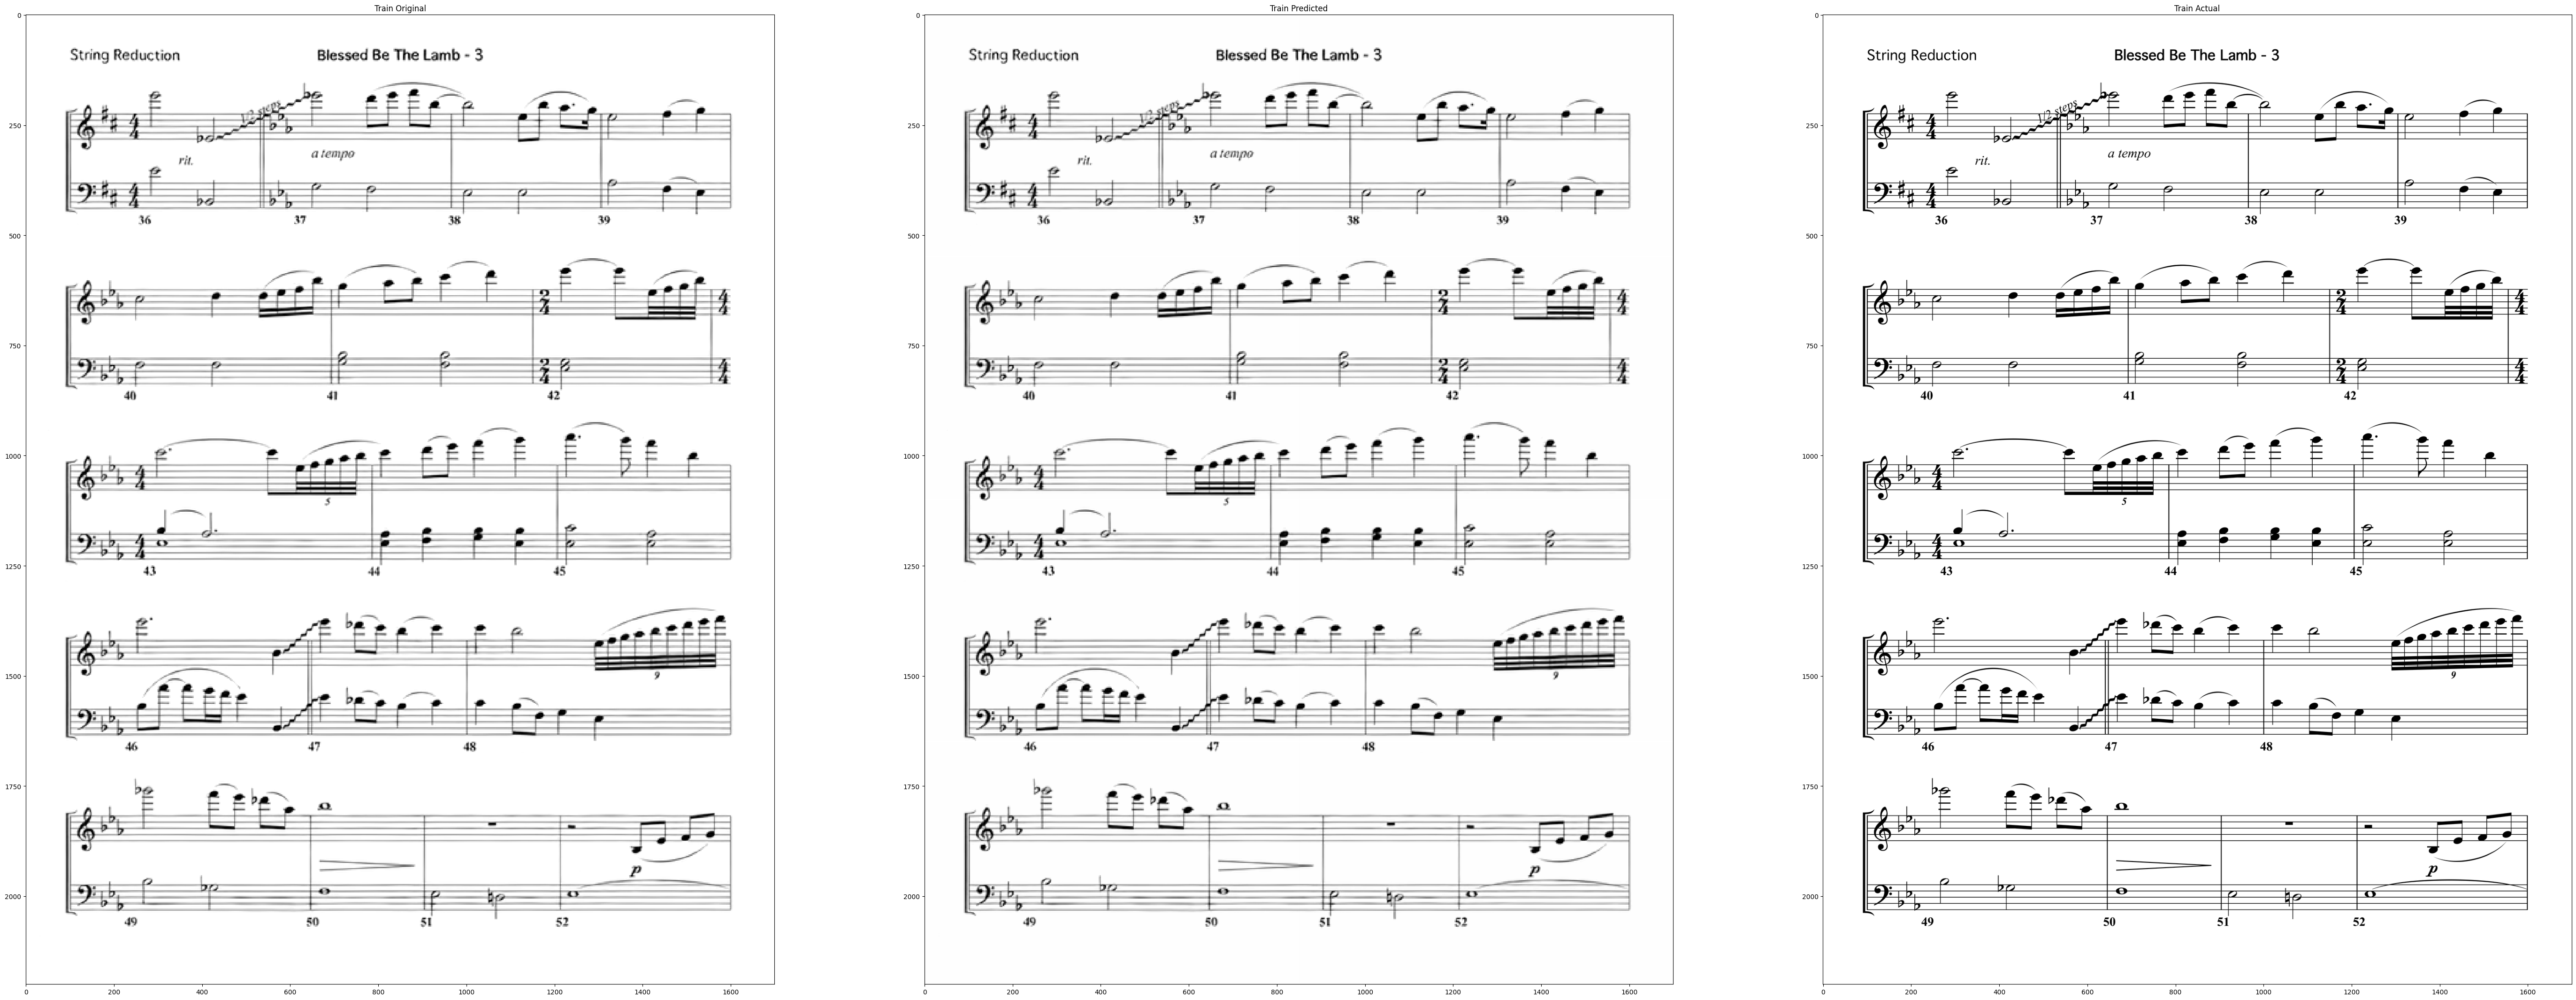

Batch 2: Training Loss: 0.175122

In [ ]:
model_results = train(model_name = 'model',
                        model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        patch_height=PATCH_HEIGHT,
                        patch_width=PATCH_WIDTH,
                        max_epochs=MAX_EPOCHS,
                        save_epochs=SAVE_EPOCHS,
                        device=device,
                        load_model=LOAD_MODEL,
                        save_model=SAVE_MODEL,
                        continue_training=CONTINUE_TRAINING,
                        print_images=PRINT_IMAGES)

In [ ]:
plot_train_val_loss(model_results, model, image_dir_path=image_dir_path)